In [1]:
!pip install yfinance

In [2]:
#importing yfinance
import yfinance as yf
#Collecting data
data = yf.download('ESCORTS.NS',period='5y',interval='1d')


[*********************100%%**********************]  1 of 1 completed


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

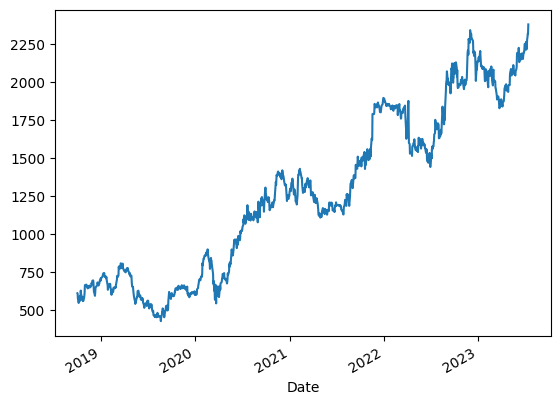

In [4]:
data_target = data.iloc[:1182,4]
data_test = data.iloc[1132:,4]
steps = 7
#return numpy representation of data
data = data.loc[:,["Adj Close"]].values
test = data[len(data) - len(data_test) - steps:]
#4 the column is Adj Close
plot = data_target.plot()

In [5]:
#Scaling Dataset
def scaledata(data_target):
    #Import scaler and initialise it
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    #transform by converting it to array and shape of (-1,1)
    data_target_scaled = scaler.fit_transform(np.array(data_target).reshape(-1,1))
    #plot the scaled version of data
    plot_scaled = pd.DataFrame(data_target_scaled).plot()
    print(data_target.shape)
    #returns scaled data
    return data_target_scaled, scaler

In [6]:
#Create pattern and end price set
def createPatternSet(data_target_scaled,steps=7):
    x_patern = []  #Independent Variable
    y_price = []   #Dependent Variable
    for day in range(steps,data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day,0]
        #print(len(row))
        x_patern.append(row)
        y = data_target_scaled[day,0]
        #print(y)
        y_price.append(y)

    x_patern,y_price = np.array(x_patern),np.array(y_price)
    #RNN and LSTM takes 3D inputs, we need to change the shape of array to 3 dimensional.
    x_patern = x_patern.reshape(x_patern.shape[0],x_patern.shape[1],1)
    #returns independent and dependent variable sets
    return x_patern,y_price

(1182,)
(1182,)


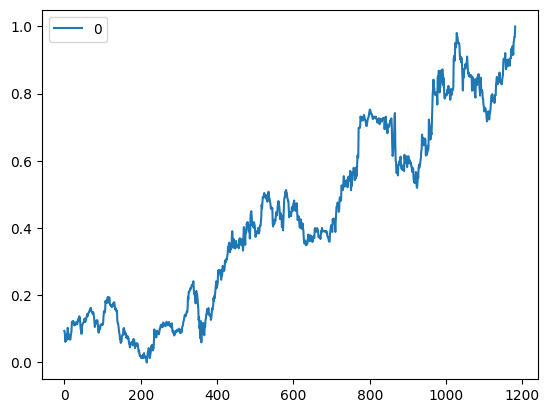

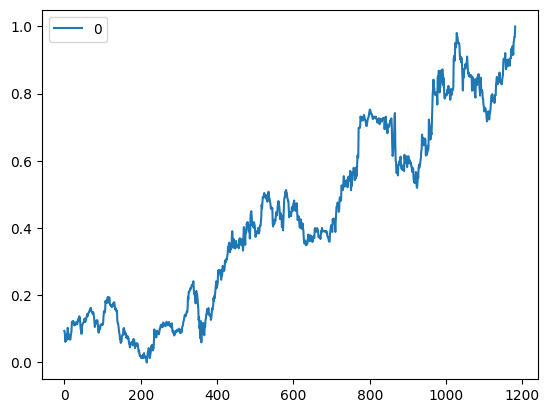

In [7]:
#Scale Down Target
data_target_scaled = scaledata(data_target)[0]
scaler = scaledata(data_target)[1]
#prepare test data
test = data[len(data) - len(data_test) - steps:]
test = scaler.transform(test)

(104,)


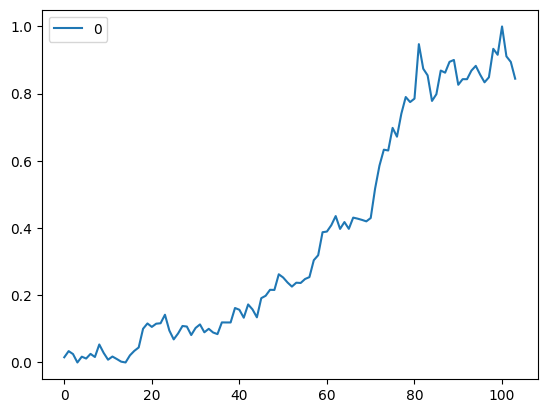

In [8]:
data_test_scaled = scaledata(data_test)[0]

In [9]:
#Create pattern and end price set
def createPatternSet(data_target_scaled,steps=7):
    x_patern = []
    y_price = []

    for day in range(steps,data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day,0]
        #print(len(row))
        x_patern.append(row)
        y = data_target_scaled[day,0]
        #print(y)
        y_price.append(y)

    x_patern,y_price = np.array(x_patern),np.array(y_price)
    x_patern = x_patern.reshape(x_patern.shape[0],x_patern.shape[1],1)

    return x_patern,y_price

In [10]:
train_pattern = createPatternSet(data_target_scaled,steps=50)

In [11]:
x_train = train_pattern[0]
y_train = train_pattern[1]

In [12]:
x_train.shape

(1132, 50, 1)

In [13]:
y_train.shape

(1132,)

In [14]:
x_train

array([[[0.0939721 ],
        [0.09240872],
        [0.0755891 ],
        ...,
        [0.11197682],
        [0.1132629 ],
        [0.11606192]],

       [[0.09240872],
        [0.0755891 ],
        [0.06134163],
        ...,
        [0.1132629 ],
        [0.11606192],
        [0.1192897 ]],

       [[0.0755891 ],
        [0.06134163],
        [0.06714147],
        ...,
        [0.11606192],
        [0.1192897 ],
        [0.12019749]],

       ...,

       [[0.79628731],
        [0.79549479],
        [0.82921807],
        ...,
        [0.91594856],
        [0.95337038],
        [0.95801273]],

       [[0.79549479],
        [0.82921807],
        [0.83793637],
        ...,
        [0.95337038],
        [0.95801273],
        [0.96968297]],

       [[0.82921807],
        [0.83793637],
        [0.84995302],
        ...,
        [0.95801273],
        [0.96968297],
        [0.96942648]]])

In [15]:
class StocksPriceRNN():

    loss='mean_squared_error'
    batch_size=32
    neurons = 50
    model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        self.x_train = x_train
        self.y_train = y_train
        self.epoch = epoch

    def buildArchitecture(self,rnn=2,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                            activation='tanh',
                                            return_sequences = True,
                                            input_shape = (self.x_train.shape[1],1)))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        for i in range(rnn):
            StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = True))
            StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))

        #return sequense changed to false
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = False))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))

        for i in range(dense):
            StocksPriceRNN.model.add(tf.keras.layers.Dense(units=StocksPriceRNN.neurons,
                                            activation='tanh'))

        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()

    def compiler(self):
        opt= tf.keras.optimizers.Adam()
        StocksPriceRNN.model.compile(optimizer = opt,
                                    loss = StocksPriceRNN.loss)
        return StocksPriceRNN.model.summary()

    def modelfit(self):
        history = StocksPriceRNN.model.fit(self.x_train,self.y_train,
                                        epochs=self.epoch,batch_size=StocksPriceRNN.batch_size,validation_split=0.2,
                                       )
        return history

    def changeBatchSize(self,size):
        StocksPriceRNN.batch_size = size
        print("Changed!")
    def changeNeurons(self,size):
        StocksPriceRNN.neurons = size
        print("Changed!")
    def changeEpoch(self,size):
        self.epoch = size
        print("Changed!")

In [16]:
RNN1 = StocksPriceRNN(x_train,y_train,50)

In [17]:
RNN1.buildArchitecture(2,0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [18]:
RNN1.compiler()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [19]:
history = RNN1.modelfit()

Epoch 1/50
29/29 [==============================] - 9s 148ms/step - loss: 0.3766 - val_loss: 0.0460
Epoch 2/50
29/29 [==============================] - 3s 120ms/step - loss: 0.2230 - val_loss: 0.0057
Epoch 3/50
29/29 [==============================] - 3s 107ms/step - loss: 0.1762 - val_loss: 0.0145
Epoch 4/50
29/29 [==============================] - 5s 160ms/step - loss: 0.1418 - val_loss: 0.0020
Epoch 5/50
29/29 [==============================] - 3s 111ms/step - loss: 0.1198 - val_loss: 0.0311
Epoch 6/50
29/29 [==============================] - 3s 108ms/step - loss: 0.1075 - val_loss: 0.0088
Epoch 7/50
29/29 [==============================] - 3s 116ms/step - loss: 0.0790 - val_loss: 0.0075
Epoch 8/50
29/29 [==============================] - 4s 148ms/step - loss: 0.0601 - val_loss: 0.0086
Epoch 9/50
29/29 [==============================] - 3s 117ms/step - loss: 0.0599 - val_loss: 0.0190
Epoch 10/50
29/29 [==============================] - 3s 119ms/step - loss: 0.0559 - val_loss: 0.0061

In [20]:
#Prepare Test Data
test = data[len(data) - len(data_test) - 50:]
test = scaler.transform(test)

In [21]:
test_pattern = createPatternSet(test,steps=50)
x_test = test_pattern[0]
y_test = test_pattern[1]

In [22]:
#Predict the value for test set
y_test

array([0.83793637, 0.84995302, 0.84420044, 0.82778628, 0.83911249,
       0.83548207, 0.84458392, 0.83844772, 0.86294128, 0.84645035,
       0.83320648, 0.83939377, 0.83453602, 0.82937136, 0.82781176,
       0.84166924, 0.85043895, 0.85706082, 0.893622  , 0.90397674,
       0.89725255, 0.90351649, 0.90436034, 0.92100457, 0.89024707,
       0.87286131, 0.88444338, 0.89901679, 0.89796841, 0.88134974,
       0.89520715, 0.90211031, 0.88671885, 0.89351981, 0.88633537,
       0.8831905 , 0.90602214, 0.90591994, 0.90591994, 0.93415926,
       0.93072234, 0.91520476, 0.94111014, 0.93141491, 0.91594856,
       0.95337038, 0.95801273, 0.96968297, 0.96942648, 1.        ,
       0.99371602, 0.98396945, 0.97596695, 0.98355904, 0.98304606,
       0.9907664 , 0.99448549, 1.02749565, 1.03724223, 1.08212778,
       1.08346144, 1.09582426, 1.11367591, 1.0886169 , 1.10197999,
       1.08871947, 1.11064926, 1.1086487 , 1.10621206, 1.103365  ,
       1.1098798 , 1.16730762, 1.21219317, 1.24333102, 1.24174

In [23]:
x_test

array([[[0.84895587],
        [0.84959509],
        [0.851973  ],
        ...,
        [0.79628731],
        [0.79549479],
        [0.82921807]],

       [[0.84959509],
        [0.851973  ],
        [0.85821139],
        ...,
        [0.79549479],
        [0.82921807],
        [0.83793637]],

       [[0.851973  ],
        [0.85821139],
        [0.84841898],
        ...,
        [0.82921807],
        [0.83793637],
        [0.84995302]],

       ...,

       [[0.98396945],
        [0.97596695],
        [0.98355904],
        ...,
        [1.44028877],
        [1.42861853],
        [1.48389188]],

       [[0.97596695],
        [0.98355904],
        [0.98304606],
        ...,
        [1.42861853],
        [1.48389188],
        [1.42554067]],

       [[0.98355904],
        [0.98304606],
        [0.9907664 ],
        ...,
        [1.48389188],
        [1.42554067],
        [1.41466556]]])

In [24]:
pred = RNN1.model.predict(x=x_test)
pred.shape

4/4 [==============================] - 1s 12ms/step


(104, 1)

In [25]:
#Transform back the inverse value

output = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))

In [26]:
output

array([[1951.3695],
       [1960.8948],
       [1981.5918],
       [1999.8593],
       [2007.721 ],
       [2013.264 ],
       [2016.023 ],
       [2013.9349],
       [2013.2465],
       [2023.2986],
       [2028.877 ],
       [2028.145 ],
       [2027.4457],
       [2020.9905],
       [2017.4218],
       [2011.572 ],
       [2016.217 ],
       [2018.3306],
       [2022.6056],
       [2035.2881],
       [2060.515 ],
       [2077.159 ],
       [2087.2942],
       [2093.8308],
       [2105.7463],
       [2104.5737],
       [2099.2354],
       [2096.4675],
       [2096.5056],
       [2090.3914],
       [2088.2583],
       [2092.5527],
       [2096.3892],
       [2097.9592],
       [2100.5544],
       [2094.8293],
       [2088.8743],
       [2089.8518],
       [2102.5627],
       [2108.1047],
       [2109.799 ],
       [2119.0076],
       [2132.2363],
       [2138.829 ],
       [2133.073 ],
       [2131.6255],
       [2145.1824],
       [2150.8972],
       [2156.2058],
       [2169.4958],


In [27]:
def plotting(org_vals,output):
    plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(org_vals,color="Green",label="Org value")
    plt.plot(output,color="Yellow",label="Predicted")
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

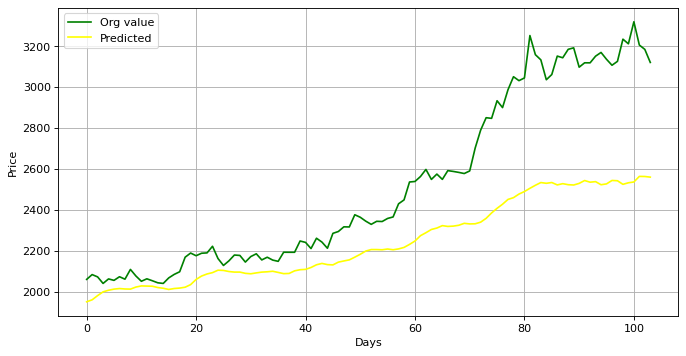

In [28]:
plotting(org_vals,output)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(org_vals, pred)
print("Mean Absolute Error:", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(org_vals, pred)
print("Mean Squared Error:", mse)

# Calculate R-squared
r2 = r2_score(org_vals, pred)
print("R-squared:", r2)

Mean Absolute Error: 2516.6014479908804
Mean Squared Error: 6509054.482185706
R-squared: -36.01377780895795
